<a href="https://colab.research.google.com/github/AdityaSai2004/Oil-pricing/blob/main/Updated_LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential


In [ ]:
column_names = ["Date", "OilPrice"]
brent_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls", sheet_name=1, skiprows=4, engine='xlrd',names=column_names)
print(brent_data.head())

        Date  OilPrice
0 1987-05-22     18.55
1 1987-05-25     18.60
2 1987-05-26     18.63
3 1987-05-27     18.60
4 1987-05-28     18.60


In [ ]:
oil_prices = brent_data['OilPrice']
dates = brent_data['Date']


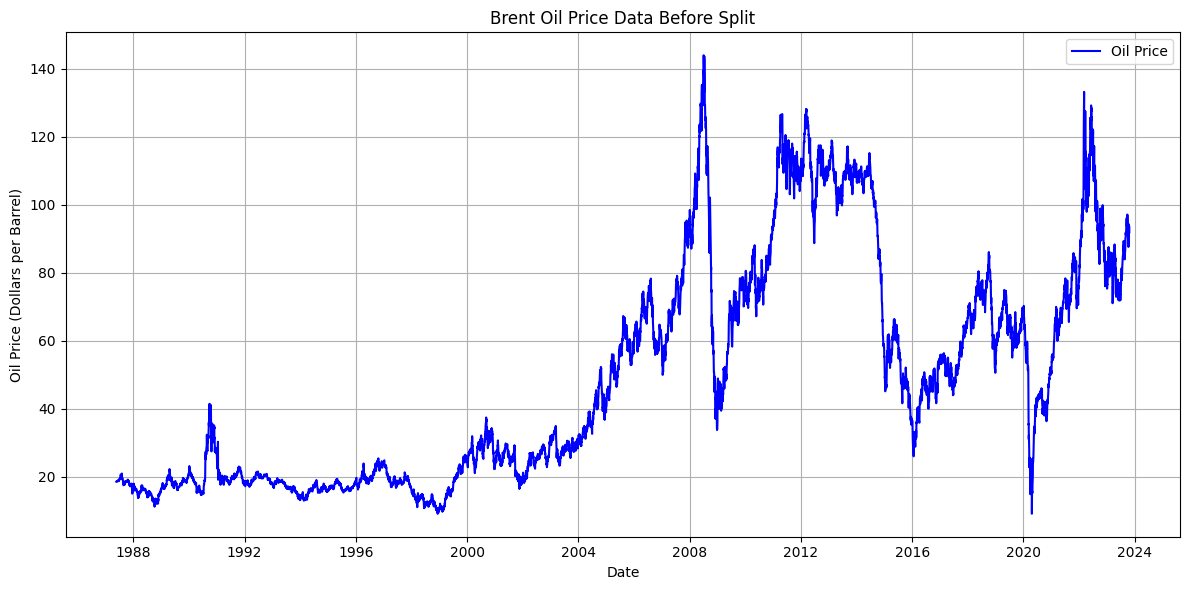

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(brent_data['Date'], brent_data['OilPrice'], label='Oil Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price Data Before Split')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
scaler = MinMaxScaler()
brent_data['normalized_oil_prices'] = scaler.fit_transform(brent_data['OilPrice'].values.reshape(-1, 1))
brent_data.head()

,Date,OilPrice,normalized_oil_prices
0,1987-05-22,18.55,0.070078
1,1987-05-25,18.60,0.070449
2,1987-05-26,18.63,0.070671
3,1987-05-27,18.60,0.070449
4,1987-05-28,18.60,0.070449


In [ ]:
split_date = pd.to_datetime("2010-01-01")
cutoff_date = pd.to_datetime("2023-01-01")

nearest_date = brent_data.loc[brent_data['Date'] >= split_date, 'Date'].min()
nearest_cutoff = brent_data.loc[brent_data['Date'] >= cutoff_date, 'Date'].min()

split_index = brent_data[brent_data['Date'] == nearest_date].index[0]
cutoff_index = brent_data[brent_data['Date'] == nearest_cutoff].index[0]

train_values = brent_data['normalized_oil_prices'][split_index:cutoff_index]
train_dates = brent_data['Date'][split_index:cutoff_index]

test_values = brent_data['normalized_oil_prices'][cutoff_index:]
test_real = brent_data['OilPrice'][cutoff_index:]
test_dates = brent_data['Date'][cutoff_index:]

train_values = train_values.reset_index(drop=True)
train_dates = train_dates.reset_index(drop=True)
test_values = test_values.reset_index(drop=True)
test_dates = test_dates.reset_index(drop=True)
test_real = test_real.reset_index(drop=True)

In [ ]:
print(test_real)

0      80.36
1      75.31
2      76.73
3      76.41
4      77.50
       ...  
199    92.52
200    91.99
201    93.12
202    93.72
203    91.88
Name: OilPrice, Length: 204, dtype: float64


In [ ]:
print(train_values)
print(train_dates)
print(test_values)
print(test_dates)

0       0.518725
1       0.520356
2       0.526808
3       0.529996
4       0.526214
          ...   
3285    0.522655
3286    0.543938
3287    0.538376
3288    0.532888
3289    0.546681
Name: normalized_oil_prices, Length: 3290, dtype: float64
0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
3285   2022-12-22
3286   2022-12-23
3287   2022-12-28
3288   2022-12-29
3289   2022-12-30
Name: Date, Length: 3290, dtype: datetime64[ns]
0      0.528439
1      0.490990
2      0.501520
3      0.499147
4      0.507230
         ...   
199    0.618613
200    0.614683
201    0.623063
202    0.627512
203    0.613867
Name: normalized_oil_prices, Length: 204, dtype: float64
0     2023-01-03
1     2023-01-04
2     2023-01-05
3     2023-01-06
4     2023-01-09
         ...    
199   2023-10-17
200   2023-10-18
201   2023-10-19
202   2023-10-20
203   2023-10-23
Name: Date, Length: 204, dtype: datetime64[ns]


In [ ]:
print("Training data shape:", train_values.shape)
print("Testing data shape:", test_values.shape)

Training data shape: (3290,)
Testing data shape: (204,)


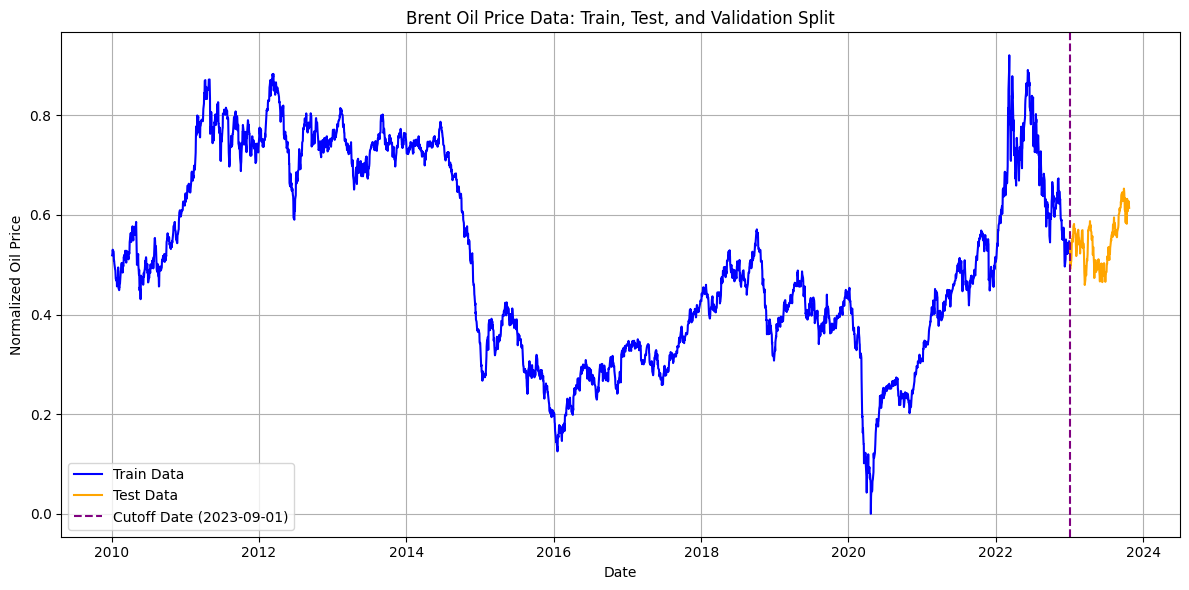

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train_values, label='Train Data', color='blue')
plt.plot(test_dates, test_values, label='Test Data', color='orange')
plt.axvline(x=nearest_cutoff, color='purple', linestyle='--', label='Cutoff Date (2023-09-01)')
plt.xlabel('Date')
plt.ylabel('Normalized Oil Price')
plt.title('Brent Oil Price Data: Train, Test, and Validation Split')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Filter the train data for February
train_feb_data = train_dates[train_dates.dt.month == 2]

# Filter the test data for February
test_feb_data = test_dates[test_dates.dt.month == 2]

# If you want to create DataFrames with the corresponding prices for February, you can do:
test_feb_prices = test_values[test_dates.dt.month == 2]
test_feb_df = pd.DataFrame({'Date': test_feb_data, 'Price': test_feb_prices})

In [ ]:
test_feb_df.head()

,Date,Price
21,2023-02-01,0.537709
22,2023-02-02,0.529996
23,2023-02-03,0.517241
24,2023-02-06,0.529329
25,2023-02-07,0.547423


In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length (number of time steps to look back)
sequence_length = 7

In [ ]:
X_train, y_train = create_sequences(train_values, sequence_length)
X_test, y_test = create_sequences(test_values, sequence_length)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3283, 7)
(3283,)
(197, 7)
(197,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3283, 7, 1)
(3283,)
(197, 7, 1)
(197,)


In [ ]:
# Step 2: Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Step 3: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Step 4: Fit the model to the training data
model.fit(X_train, y_train, epochs=25, batch_size=32)

# Step 5: Evaluate the model on the test data
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/25
103/103 [==============================] - 3s 6ms/step - loss: 0.0318
Epoch 2/25
103/103 [==============================] - 1s 6ms/step - loss: 6.9564e-04
Epoch 3/25
103/103 [==============================] - 1s 6ms/step - loss: 5.3377e-04
Epoch 4/25
103/103 [==============================] - 1s 6ms/step - loss: 5.3194e-04
Epoch 5/25
103/103 [==============================] - 1s 8ms/step - loss: 5.1246e-04
Epoch 6/25
103/103 [==============================] - 2s 19ms/step - loss: 5.1419e-04
Epoch 7/25
103/103 [==============================] - 1s 8ms/step - loss: 4.8771e-04
Epoch 8/25
103/103 [==============================] - 1s 6ms/step - loss: 4.7699e-04
Epoch 9/25
103/103 [==============================] - 1s 6ms/step - loss: 4.7404e-04
Epoch 10/25
103/103 [==============================] - 1s 6ms/step - loss: 4.5609e-04
Epoch 11/25
103/103 [==============================] - 1s 6ms/step - loss: 4.5408e-04
Epoch 12/25
103/103 [==============================] - 1s 6ms/step

In [ ]:
print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.0003661286609712988
Test Loss: 0.0003790774499066174


In [ ]:
data_queue = train_values[-7:].tolist()
print(data_queue)

[0.5216907675194661, 0.5276232851316277, 0.5226548016314423, 0.5439377085650723, 0.5383759733036707, 0.5328883945124211, 0.546681497960697]


In [ ]:
print(test_values)

0      0.528439
1      0.490990
2      0.501520
3      0.499147
4      0.507230
         ...   
199    0.618613
200    0.614683
201    0.623063
202    0.627512
203    0.613867
Name: normalized_oil_prices, Length: 204, dtype: float64


In [ ]:
print(data_queue)

[0.5216907675194661, 0.5276232851316277, 0.5226548016314423, 0.5439377085650723, 0.5383759733036707, 0.5328883945124211, 0.546681497960697]


In [ ]:
import tensorflow as tf

In [ ]:
for i in data_queue:
  print(type(i))


<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [ ]:
print(test_real[0])


80.36


In [ ]:
data_queue = test_values[13:20].tolist()
print(data_queue)
print(len(data_queue))

[0.5773822766036336, 0.5816833518724509, 0.5647015202076381, 0.5634408602150537, 0.5724137931034483, 0.5655172413793104, 0.5621060437523174]
7


# Day wise prediction

Here when predicting d+1 day. d days original values are given

In [ ]:
predicted_prices = []
data_queue = test_values[13:20].tolist()
original_prices = test_real[20:50].tolist()
for day in range(20,50):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = scaler.inverse_transform(next_day_prediction)
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(original_value)
    data_queue.pop(0)
    # print(day)

1/1 [==============================] - 0s 487ms/step
86.49575
1/1 [==============================] - 0s 26ms/step
85.974884
1/1 [==============================] - 0s 26ms/step
85.13775
1/1 [==============================] - 0s 32ms/step
84.21276
1/1 [==============================] - 0s 27ms/step
83.03569
1/1 [==============================] - 0s 23ms/step
82.18153
1/1 [==============================] - 0s 23ms/step
82.015305
1/1 [==============================] - 0s 26ms/step
82.36154
1/1 [==============================] - 0s 22ms/step
82.82312
1/1 [==============================] - 0s 24ms/step
83.677956
1/1 [==============================] - 0s 22ms/step
84.60567
1/1 [==============================] - 0s 23ms/step
85.28137
1/1 [==============================] - 0s 26ms/step
85.52626
1/1 [==============================] - 0s 24ms/step
85.46173
1/1 [==============================] - 0s 23ms/step
84.95666
1/1 [==============================] - 0s 26ms/step
84.55613
1/1 [===============

In [ ]:
print(test_dates.size)
print(test_real.size)
print(len(predicted_prices))

204
204
30


In [ ]:
d = {'Dates': test_dates[20:50], 'Original': original_prices, 'Predicted': predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (df_results['Difference'] / df_results['Original']) * 100

df_results.head(30)

,Dates,Original,Predicted,Difference,Difference %
20,2023-01-31,83.42,86.495750,3.075750,3.687066
21,2023-02-01,81.61,85.974884,4.364884,5.348467
22,2023-02-02,80.57,85.137749,4.567749,5.669292
23,2023-02-03,78.85,84.212761,5.362761,6.801219
24,2023-02-06,80.48,83.035690,2.555690,3.175560
25,2023-02-07,82.92,82.181534,0.738466,0.890577
26,2023-02-08,84.17,82.015305,2.154695,2.559933
27,2023-02-09,83.46,82.361542,1.098458,1.316149
28,2023-02-10,85.46,82.823120,2.636880,3.085514
29,2023-02-13,85.98,83.677956,2.302044,2.677418


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 2.66


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  2.80900679069357


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  2.304541310628255


Next Range

In [ ]:
predicted_prices = []
data_queue = test_values[63:70].tolist()
original_prices = test_real[70:100].tolist()
for day in range(70,100):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = scaler.inverse_transform(next_day_prediction)
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(original_value)
    data_queue.pop(0)
    # print(day)

1/1 [==============================] - 0s 21ms/step
87.137215
1/1 [==============================] - 0s 22ms/step
87.666374
1/1 [==============================] - 0s 20ms/step
87.86389
1/1 [==============================] - 0s 27ms/step
87.71387
1/1 [==============================] - 0s 22ms/step
87.440285
1/1 [==============================] - 0s 28ms/step
87.09013
1/1 [==============================] - 0s 24ms/step
86.39499
1/1 [==============================] - 0s 26ms/step
85.70284
1/1 [==============================] - 0s 23ms/step
85.31639
1/1 [==============================] - 0s 24ms/step
84.674774
1/1 [==============================] - 0s 21ms/step
83.650795
1/1 [==============================] - 0s 22ms/step
82.776505
1/1 [==============================] - 0s 24ms/step
82.24227
1/1 [==============================] - 0s 25ms/step
81.19597
1/1 [==============================] - 0s 22ms/step
79.51079
1/1 [==============================] - 0s 24ms/step
77.81438
1/1 [=============

In [ ]:
d = {'Dates': test_dates[70:100], 'Original': original_prices, 'Predicted': predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (df_results['Difference'] / df_results['Original']) * 100

df_results.head(30)

,Dates,Original,Predicted,Difference,Difference %
70,2023-04-13,86.51,87.137215,0.627215,0.725020
71,2023-04-14,87.31,87.666374,0.356374,0.408171
72,2023-04-17,85.63,87.863892,2.233892,2.608772
73,2023-04-18,85.48,87.713867,2.233867,2.613321
74,2023-04-19,85.34,87.440285,2.100285,2.461079
75,2023-04-20,83.29,87.090134,3.800134,4.562533
76,2023-04-21,83.36,86.394989,3.034989,3.640822
77,2023-04-24,84.23,85.702843,1.472843,1.748596
78,2023-04-25,82.13,85.316391,3.186391,3.879692
79,2023-04-26,79.19,84.674774,5.484774,6.926094


In [ ]:
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 2.92


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  2.757927278622893


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  2.1540995381673183


In [ ]:
print(len(test_values))

204


Next Range

In [ ]:
predicted_prices = []
data_queue = test_values[113:120].tolist()
original_prices = test_real[120:150].tolist()
for day in range(120,150):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = scaler.inverse_transform(next_day_prediction)
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(original_value)
    data_queue.pop(0)
    # print(day)

1/1 [==============================] - 0s 21ms/step
75.651115
1/1 [==============================] - 0s 25ms/step
74.88555
1/1 [==============================] - 0s 25ms/step
74.4785
1/1 [==============================] - 0s 25ms/step
74.26594
1/1 [==============================] - 0s 23ms/step
74.25984
1/1 [==============================] - 0s 23ms/step
74.4771
1/1 [==============================] - 0s 24ms/step
74.99449
1/1 [==============================] - 0s 23ms/step
75.60735
1/1 [==============================] - 0s 25ms/step
76.2501
1/1 [==============================] - 0s 30ms/step
77.0534
1/1 [==============================] - 0s 24ms/step
77.64733
1/1 [==============================] - 0s 29ms/step
78.372444
1/1 [==============================] - 0s 23ms/step
79.152565
1/1 [==============================] - 0s 25ms/step
79.948425
1/1 [==============================] - 0s 24ms/step
80.411835
1/1 [==============================] - 0s 23ms/step
80.35463
1/1 [==================

In [ ]:
d = {'Dates': test_dates[120:150], 'Original': original_prices, 'Predicted': predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (df_results['Difference'] / df_results['Original']) * 100

df_results.head(30)

,Dates,Original,Predicted,Difference,Difference %
120,2023-06-27,71.88,75.651115,3.771115,5.246404
121,2023-06-28,73.64,74.885551,1.245551,1.691406
122,2023-06-29,73.86,74.478500,0.618500,0.837396
123,2023-06-30,74.51,74.265938,0.244062,0.327556
124,2023-07-03,74.52,74.259842,0.260158,0.349112
125,2023-07-04,76.23,74.477097,1.752903,2.299493
126,2023-07-05,76.74,74.994492,1.745508,2.274574
127,2023-07-06,76.72,75.607353,1.112647,1.450270
128,2023-07-07,78.77,76.250099,2.519901,3.199062
129,2023-07-10,77.83,77.053398,0.776602,0.997818


In [ ]:
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 1.59


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  1.7059753583416395


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  1.359177876790364


# Monthly prediction

Here when predicting d+1 day. d days predicted values are given

In [ ]:
predicted_prices = []
data_queue = train_values[-7:].tolist()
for day in range(len(test_values)):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = scaler.inverse_transform(next_day_prediction)
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(next_day_prediction[0][0])
    data_queue.pop(0)
    # print(day)

1/1 [==============================] - 0s 40ms/step
82.11156
1/1 [==============================] - 0s 34ms/step
82.44687
1/1 [==============================] - 0s 40ms/step
82.72846
1/1 [==============================] - 0s 37ms/step
83.01441
1/1 [==============================] - 0s 39ms/step
83.19823
1/1 [==============================] - 0s 38ms/step
83.43308
1/1 [==============================] - 0s 35ms/step
83.69688
1/1 [==============================] - 0s 41ms/step
83.90011
1/1 [==============================] - 0s 33ms/step
84.14563
1/1 [==============================] - 0s 39ms/step
84.38474
1/1 [==============================] - 0s 44ms/step
84.62179
1/1 [==============================] - 0s 43ms/step
84.85798
1/1 [==============================] - 0s 37ms/step
85.09705
1/1 [==============================] - 0s 36ms/step
85.33658
1/1 [==============================] - 0s 42ms/step
85.57587
1/1 [==============================] - 0s 39ms/step
85.81708
1/1 [===================

In [ ]:
print(test_dates.size)
print(test_real.size)
print(len(predicted_prices))

204
204
204


In [ ]:
d = {'Dates' : test_dates, 'Original' : test_real, 'Predicted' : predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (abs(df_results['Original'] - df_results['Predicted'])/df_results['Original'])*100

df_results.head(32)

,Dates,Original,Predicted,Difference,Difference %
0,2023-01-03,80.36,82.111557,1.751557,2.179638
1,2023-01-04,75.31,82.446869,7.136869,9.476655
2,2023-01-05,76.73,82.728462,5.998462,7.817623
3,2023-01-06,76.41,83.014412,6.604412,8.643387
4,2023-01-09,77.50,83.198227,5.698227,7.352551
5,2023-01-10,78.40,83.433083,5.033083,6.419748
6,2023-01-11,81.11,83.696877,2.586877,3.189344
7,2023-01-12,82.59,83.900108,1.310108,1.586280
8,2023-01-13,83.43,84.145630,0.715630,0.857761
9,2023-01-16,82.65,84.384743,1.734743,2.098902


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 29.25


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  31.437192451987936


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  25.87144731110218


NEXT RANGE